In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# set some seaborn aesthetics
sbn.set_palette("Set1")

In [4]:
# initialize random seed for reproducibility
np.random.seed(20160404)

In [5]:
## simulate one way ANOVA under the null hypothesis of no 
## difference in group means

groupmeans = [0, 0, 0, 0]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
allobs = np.concatenate(samples)

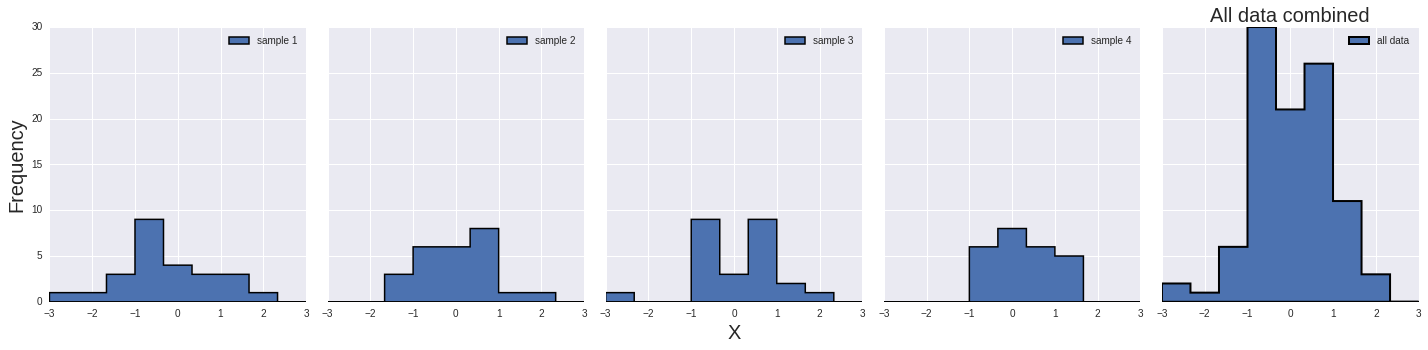

In [6]:
sbn.set_palette("deep")

bins = np.linspace(-3, 3, 10)
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axes[i].hist(sample, bins=bins, histtype='stepfilled', 
                 linewidth=1.5, label='sample {}'.format(i+1))
    axes[i].legend()

axes[-1].hist(allobs, bins=bins, histtype='stepfilled', linewidth=2, label='all data')
axes[-1].legend()
axes[-1].set_title("All data combined", fontsize=20)

axes[0].set_ylabel("Frequency", fontsize=20)
axes[2].set_xlabel("X", fontsize=20)

fig.tight_layout()
pass

In [7]:
## simulate one way ANOVA under HA

groupmeans = [0, 0, -1, 1]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
allobs = np.concatenate(samples)

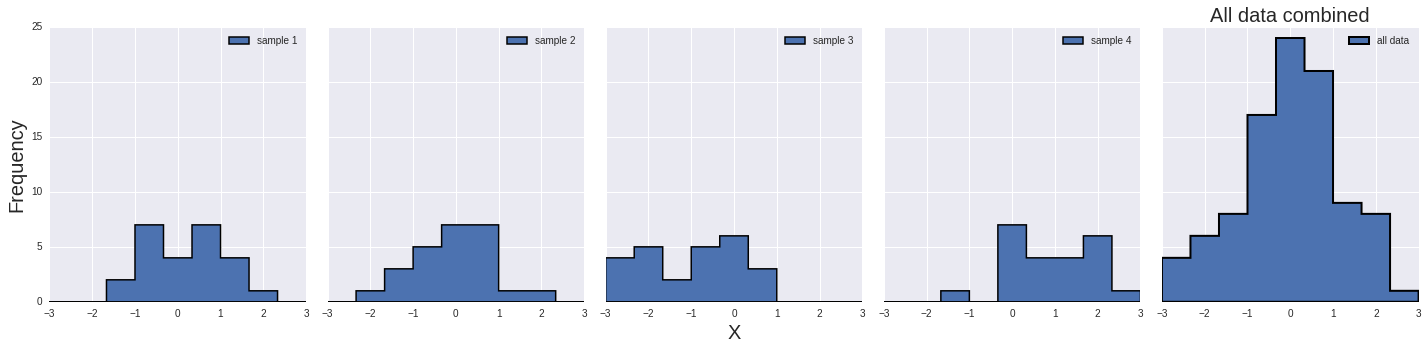

In [8]:
sbn.set_palette("deep")

bins = np.linspace(-3, 3, 10)
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axes[i].hist(sample, bins=bins, histtype='stepfilled', 
                 linewidth=1.5, label='sample {}'.format(i+1))
    axes[i].legend()

axes[-1].hist(allobs, bins=bins, histtype='stepfilled', linewidth=2, label='all data')
axes[-1].legend()
axes[-1].set_title("All data combined", fontsize=20)

axes[0].set_ylabel("Frequency", fontsize=20)
axes[2].set_xlabel("X", fontsize=20)

fig.tight_layout()
pass

In [50]:
def sum_squares_total(groups):
    allobs = np.ravel(groups)
    grandmean = np.mean(allobs)
    return np.sum((allobs - grandmean)**2)
    

def sum_squares_between(groups):
    ns = np.array([len(g) for g in groups])
    grandmean = np.mean(np.ravel(groups))
    groupmeans = np.array([np.mean(g) for g in groups])
    return np.sum(ns * (groupmeans - grandmean)**2)


def sum_squares_within(groups):
    groupmeans = np.array([np.mean(g) for g in groups])
    group_sumsquares = []
    for i in range(len(groups)):
        groupi = np.asarray(groups[i])
        groupmeani = groupmeans[i]
        group_sumsquares.append(np.sum((groupi - groupmeani)**2))
    return np.sum(group_sumsquares)
        
    
def degrees_freedom(groups):
    N = len(np.ravel(groups))
    k = len(groups)
    return k-1, N - k, N - 1

In [131]:
sum_squares_total(samples), sum_squares_between(samples), sum_squares_within(samples)

(161.41418926477886, 58.350697428692285, 103.06349183608656)

In [52]:
degrees_freedom(samples)

(3, 96, 99)

In [46]:
index = ['BtwGroup', 'WithinGroup', 'Total']
cols = ['df', 'SumSquares','MS','F','Pval']


In [132]:
tbl = pd.DataFrame(index=index, columns=cols)
tbl.df = degrees_freedom(samples)
tbl.SumSquares = sum_squares_between(samples), sum_squares_within(samples), sum_squares_total(samples)
tbl.MS = tbl.SumSquares[:2]/tbl.df[:2]
tbl.F = [tbl.MS[0]/tbl.MS[1], None, None]
tbl.Pval = [stats.f.sf(tbl.F[0], tbl.df[0], tbl.df[1]), None, None]
tbl.fillna(0)

,df,SumSquares,MS,F,Pval
BtwGroup,3,58.350697,19.450232,18.117204,2.142677e-09
WithinGroup,96,103.063492,1.073578,0.000000,0.000000e+00
Total,99,161.414189,0.000000,0.000000,0.000000e+00


In [133]:
## A useful statistic to calculate to 

R2 = 1 - (sum_squares_within(samples)/sum_squares_total(samples))
R2

0.36149670418983804

In [129]:
# wrap our ANOVA calcs into a function

def ANOVA_oneway(groups):
    index = ['BtwGroup', 'WithinGroup', 'Total']
    cols = ['df', 'SumSquares','MS','F','pval']
    
    df   = degrees_freedom(groups)
    ss   = sum_squares_between(groups), sum_square_within(groups), sum_squares_total(groups)
    ms   = ss[0]/df[0], ss[1]/df[1], ""
    F    = ms[0]/ms[1], "", ""
    pval = stats.f.sf(F[0], df[0], df[1]), "", ""
    
    tbl = pd.DataFrame(index=index, columns=cols)
    tbl.index.name = 'Source'
    tbl.df = df
    tbl.SumSquares = ss
    tbl.MS = ms
    tbl.F = F
    tbl.pval = pval
    
    return tbl
    

In [130]:
ANOVA_oneway(samples)

,df,SumSquares,MS,F,pval
Source,,,,,
BtwGroup,3,58.350697,19.4502,18.1172,2.14268e-09
WithinGroup,96,103.063492,1.07358,,
Total,99,161.414189,,,


In [121]:
# compare to scipy.stats.f_oneway
stats.f_oneway(*samples)

F_onewayResult(statistic=18.117204108393736, pvalue=2.1426767523356996e-09)

# Anderson's Iris Data revisited

In [122]:
irisurl = "https://raw.githubusercontent.com/Bio204-class/bio204-datasets/master/iris.csv"
iris = pd.read_csv(irisurl)

In [124]:
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


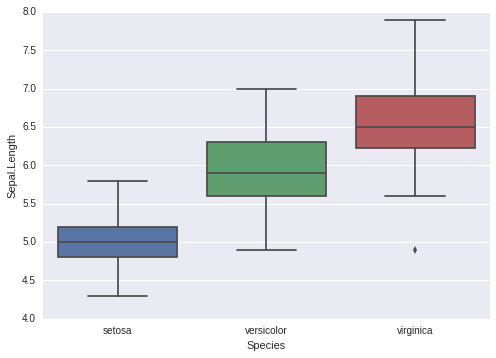

In [125]:
sbn.boxplot(x="Species", y="Sepal.Length", data=iris)

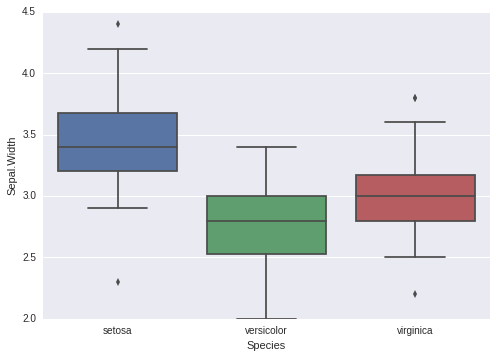

In [126]:
sbn.boxplot(x="Species", y="Sepal.Width", data=iris)

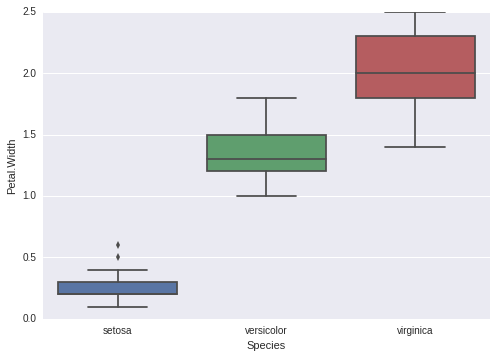

In [128]:
sbn.boxplot(x="Species", y="Petal.Width", data=iris)